## Wormholes example

This example illustrates wormholes.


### Problem Setup

Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.cvfdutil
import math

Append to system path to include the common subdirectory

In [2]:
mf6_exe = ".\\bin\\mf6.exe"

Set default figure properties

In [3]:
figure_size = (6, 6)
figure_ext = ".png"

Base simulation and model name and workspace

In [4]:
ws = '.\\wormholes'
print (ws)

.\wormholes


Model units

In [5]:
length_units = "meters"
time_units = "days"

Scenario parameters

In [6]:
parameters = {
    "worm-smth-s": {
        "xt3d": False,
        "xgapfrac": 0.999,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-smth-x-i": {
        "xt3d": True,
        "xgapfrac": 0.999,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-zzag-s": {
        "xt3d": False,
        "xgapfrac": 0.5,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-zzag-x-i": {
        "xt3d": True,
        "xgapfrac": 0.5,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-zzag-x-a": {
        "xt3d": True,
        "xgapfrac": 0.5,
        "k11gapx": 1000.,
        "k22gapx": 0.001,
    },
    "worm-sstp-s": {
        "xt3d": False,
        "xgapfrac": 0.001,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-sstp-x-i": {
        "xt3d": True,
        "xgapfrac": 0.001,
        "k11gapx": 1.,
        "k22gapx": 1.,
    },
    "worm-sstp-x-a": {
        "xt3d": True,
        "xgapfrac": 0.001,
        "k11gapx": 1000.,
        "k22gapx": 0.001,
    },
}

Table Model Parameters

In [7]:
# adjustable grid parameters applied to all scenarios;
#   "nominal" refers to the regular grid one would have in the absence
#    of vertical offsets and "gap" cells
nrow = 6  # Number of rows
ncol = 11  # Nominal number of columns
theta = 30.  # Angle of channel from horizontal ($deg$)

# fixed parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
top = 0.0  # Top of the model ($m$)
botm = -1.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11base = 1.0  # Horizontal hydraulic conductivity ($m/d$) of all cells when not using xt3d, and "flat-top" cells when using xt3d
hgrad = -1.  # Unit head gradient to produce unit specific discharge with k11 = 1.0

Computed Parameters

In [8]:
ncolactual = 2 * ncol - 1
thetarad = theta * math.pi / 180.
sintheta = math.sin(thetarad)
costheta = math.cos(thetarad)
tantheta = math.tan(thetarad)
delx = 10. / (ncol - 1)  # x spacing
dely = delx  # y spacing set to x spacing
yoffset = delx * tantheta  # vertical offset due to channel angle

Static temporal data used by TDIS file
Simulation has 1 steady stress period (1 day).

In [9]:
perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

create vertices

In [10]:
def create_vertices(xgapfrac):
    global verts, iverts

    xgapoff = 0.5 * xgapfrac * delx
    nverts = (nrow + 1) * (ncolactual + 1)
    verts = np.empty((nverts, 2), dtype=float)
    ivert = -1
    for ivrow in range(nrow + 1):
        ynominal = (nrow - ivrow) * dely
        for jvcol in range(ncolactual + 1):
            xnominal = jvcol * 0.5 * delx
            if (jvcol % 2) == 0:
                x = xnominal + xgapoff
            else:
                x = xnominal + 0.5 * delx - xgapoff
            y = ynominal + yoffset * int(jvcol / 2)
            ivert += 1
            verts[ivert, 0] = x
            verts[ivert, 1] = y

    iverts = []
    icell1based = 0
    for irow in range(nrow):
        for jcol in range(ncolactual):
            icell1based += 1
            ivert2 = icell1based + irow
            ivert1 = ivert2 - 1
            ivert4 = ivert2 + ncolactual
            ivert3 = ivert4 + 1
            ivlist = [ivert1, ivert2, ivert3, ivert4, ivert1]
            iverts.append(ivlist)

    return verts, iverts

Solver parameters

In [11]:
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

Analytical head and cell conductivities

In [12]:
def calculate_head_analyt():
    global hgrad, costheta, sintheta
    global head_analyt

    hgradx = hgrad * costheta
    hgrady = hgrad * sintheta

    head_analyt = []

    icell = -1
    for irow in range(nrow):
        for jcol in range(ncolactual):
            icell += 1
            ivlist = iverts[icell]
            xctr = 0.
            yctr = 0.
            for i in range(4):
                xctr += verts[ivlist[i], 0]
                yctr += verts[ivlist[i], 1]
            xctr = 0.25 * xctr
            yctr = 0.25 * yctr
            h = hgradx * xctr + hgrady * yctr
            head_analyt.append(h)

    return

Set anisotropic cell conductivities

In [13]:
def set_cond_aniso(k11gapx, k22gapx, k11x, k22x, angle1x):

    for irow in range(nrow):
        for jcol in range(ncolactual):
            if (jcol % 2) == 0:
                k11x.append(k11base)
                angle1x.append(0.)
                k22x.append(k11base)
            else:
                k11x.append(k11gapx)
                slope = (verts[2, 1] - verts[1, 1]) / (verts[2, 0] - verts[1, 0])
                angle = math.atan(slope) * 180. / math.pi
                angle1x.append(angle)
                k22x.append(k22gapx)

    return

### Functions to build, write, run, and plot the MODFLOW 6 model

MODFLOW 6 flopy simulation object (sim) is returned if building the model

In [14]:
def build_model(sim_name, xt3d, xgapfrac, k11gapx, k22gapx):
    verts, iverts = create_vertices(xgapfrac)
    gridprops = flopy.utils.cvfdutil.get_disv_gridprops(verts, iverts)
    
    sim_ws = os.path.join(ws, sim_name)
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name, sim_ws=sim_ws, exe_name=mf6_exe
    )
    flopy.mf6.ModflowTdis(
        sim, nper=nper, perioddata=tdis_ds, time_units=time_units
    )
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord="{} strict".format(rclose),
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True, print_flows=True)
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nlay=nlay,
        top=top,
        botm=botm,
        **gridprops,
    )
    
    if xt3d:
        k11x = []
        k22x = []
        angle1x = []
        set_cond_aniso(k11gapx, k22gapx, k11x, k22x, angle1x)
        flopy.mf6.ModflowGwfnpf(
            gwf,
            icelltype=icelltype,
            k=k11x, k22=k22x, angle1=angle1x,
            save_specific_discharge=True,
            xt3doptions=xt3d,
        )
    else:
        flopy.mf6.ModflowGwfnpf(
            gwf,
            icelltype=icelltype,
            k=k11base,
            save_specific_discharge=True,
            xt3doptions=xt3d,
        )
    print (xt3d)

    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    calculate_head_analyt()

    chd_spd = []
    chd_spd += [[0, i * ncolactual,
                head_analyt[i * ncolactual]]
                for i in range(nrow)]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-LEFT",
        filename="{}.left.chd".format(sim_name),
    )

    chd_spd = []
    chd_spd += [[0, (i + 1) * ncolactual - 1,
                 head_analyt[(i + 1) * ncolactual - 1]]
                 for i in range(nrow)]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-RIGHT",
        filename="{}.right.chd".format(sim_name),
    )

    head_filerecord = "{}.hds".format(sim_name)
    budget_filerecord = "{}.cbc".format(sim_name)
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord = [('BUDGET', 'ALL'), ('HEAD', 'ALL')],
    )

    return sim

Function to write MODFLOW 6 model files

In [15]:
def write_model(sim, silent=True):
    sim.write_simulation(silent=silent)

Function to run the FHB model.
True is returned if the model runs successfully


In [16]:
def run_model(sim, silent=False):
    success = True
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    return success

In [17]:
# Function to plot the model results.
#
def plot_grid(idx, sim):
###    fs = USGSFigure(figure_type="map", verbose=False)
    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)

    fig = plt.figure(figsize=figure_size)
    fig.tight_layout()

    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
    pmv.plot_grid()
    pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
    pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    for i, (x, y) in enumerate(
        zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
    ):
        ax.text(
            x,
            y,
            "{}".format(i + 1),
            fontsize=6,
            horizontalalignment="center",
            verticalalignment="center",
        )
    v = gwf.disv.vertices.array
    ax.plot(v["xv"], v["yv"], "yo")
    for i in range(v.shape[0]):
        x, y = v["xv"][i], v["yv"][i]
        ax.text(
            x,
            y,
            "{}".format(i + 1),
            fontsize=5,
            color="red",
            horizontalalignment="center",
            verticalalignment="center",
        )

    # save figure
    fpth = os.path.join(
        "..", "figures", "{}-grid{}".format(sim_name, figure_ext)
    )
    fig.savefig(fpth)
    return

In [18]:
def plot_head(idx, sim):
    from tabulate import tabulate
###    fs = USGSFigure(figure_type="map", verbose=False)
    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)

    fig = plt.figure(figsize=(12, 8))
    fig.tight_layout()

    fname = os.path.join(sim_ws, "{}.hds".format(sim_name))
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()[:, 0, :]

    # create MODFLOW 6 cell-by-cell budget object
    file_name = gwf.oc.budget_filerecord.get_data()[0][0]
    fpth = os.path.join(sim_ws, file_name)
    cobj = flopy.utils.CellBudgetFile(fpth, precision="double")
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
        gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
        gwf,
    )

    # print specific discharge summary
    print_spdis_summary(qx, qy, qz)
    
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
    pmv.plot_grid()
    cb = pmv.plot_array(head, cmap="jet")
    pmv.plot_vector(qx, qy, -qz, scale = 10, color='black', headwidth=2, headlength=0.1, headaxislength=2.)
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Head, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
###    fs.heading(ax, letter="A", heading="Simulated Head")

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
    pmv.plot_grid()
    cb = pmv.plot_array(head - np.array(head_analyt), cmap="jet")
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Error, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
###    fs.heading(ax, letter="B", heading="Error")

    # save figure
    fpth = os.path.join(
        "..", "figures", "{}-head{}".format(sim_name, figure_ext)
    )
    fig.savefig(fpth)
    return

In [19]:
def print_spdis_summary(qx, qy, qz):
    from tabulate import tabulate

    jcolactualmid = math.ceil(ncolactual / 2)
    jcolmid = int(ncol / 2)
    irowmid = int(nrow / 2)
    
    qmagminf = qangminf = qmagmidf = float('inf')
    qmagmaxf = qangmaxf = qangmidf = float('-inf')
    qmagavgf = qangavgf = 0.
    ncountf = 0
    qmagminc = qangminc = qmagmidc = float('inf')
    qmagmaxc = qangmaxc = qangmidc = float('-inf')
    qmagavgc = qangavgc = 0.
    ncountc = 0
    qmagmin = qangmin = float('inf')
    qmagmax = qangmax = float('-inf')
    icell = -1
    for irow in range(nrow):
        for jcolactual in range(ncolactual):
            icell += 1
            qqx = qx[0][icell]
            qqy = qy[0][icell]
            qmag = math.sqrt(qqx * qqx + qqy * qqy)
            if (qqx == 0.):
                if (qqy == 0.):
                    qang = 0.
                elif (qqy > 0.):
                    qang = 90.
                else:
                    qang = -90.
            else:
                qang = math.atan(qqy / qqx) * 180. / math.pi
            if (jcolactual % 2) == 0:
                ncountf += 1
                qmagminf = min([qmagminf, qmag])
                qmagmaxf = max([qmagmaxf, qmag])
                qmagavgf += qmag
                qangminf = min([qangminf, qang])
                qangmaxf = max([qangmaxf, qang])
                qangavgf += qang
                jcol = jcolactual / 2
                if (irow == irowmid) and (jcol == jcolmid):
                    qmagmidf = qmag
                    qangmidf = qang
            else:
                ncountc += 1
                qmagminc = min([qmagminc, qmag])
                qmagmaxc = max([qmagmaxc, qmag])
                qmagavgc += qmag
                qangminc = min([qangminc, qang])
                qangmaxc = max([qangmaxc, qang])
                qangavgc += qang
                if (irow == irowmid) and (jcolactual == jcolactualmid):
                    qmagmidc = qmag
                    qangmidc = qang
            qmagmin = min([qmagmin, qmag])
            qmagmax = max([qmagmax, qmag])
            qangmin = min([qangmin, qang])
            qangmax = max([qangmax, qang])
    qmagavg = qmagavgf + qmagavgc
    qangavg = qangavgf + qangavgc
    ncount = ncountf + ncountc
    qmagavgf = qmagavgf / ncountf
    qangavgf = qangavgf / ncountf
    qmagavgc = qmagavgc / ncountc
    qangavgc = qangavgc / ncountc
    qmagavg = qmagavg / ncount
    qangavg = qangavg / ncount
    qmagana = -k11base * hgrad
    qangana = theta

    print ("\nSPECIFIC DISCHARGE:")
    qdata = [
        ["analytical", qmagana, qangana],
        ["flat-tops, mid-channel", qmagmidf, qangmidf],
        ["flat-tops, avg", qmagavgf, qangavgf],
        ["flat-tops, min", qmagminf, qangminf],
        ["flat-tops, max", qmagmaxf, qangmaxf],
        ["connectors, mid-channel", qmagmidc, qangmidc],
        ["connectors, avg", qmagavgc, qangavgc],
        ["connectors, min", qmagminc, qangminc],
        ["connectors, max", qmagmaxc, qangmaxc],
        ["all, avg", qmagavg, qangavg],
        ["all, min", qmagmin, qangmin],
        ["all, max", qmagmax, qangmax],
    ]
    qhead = ["", "magnitude", "angle",]
    print(tabulate(qdata, headers=qhead, tablefmt="simple", floatfmt=".14f"))
    
    return

In [20]:
def plot_results(idx, sim, silent=True):
#    if idx == 0:
#        plot_grid(idx, sim)
    plot_head(idx, sim)
    return

Function that wraps all of the steps for the FHB model

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [21]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_model(key, **params)
    write_model(sim, silent=silent)
    success = run_model(sim, silent=silent)
    if success:
        plot_results(idx, sim, silent=silent)

### Simulation

Simulation results for scenario 0, which features:
1. nearly smooth channel boundary
2. standard conductance formulation
3. isotropic connector cells

The connector cells are of primary interest in this scenario.

False

SPECIFIC DISCHARGE:
                                magnitude              angle
-----------------------  ----------------  -----------------
analytical               1.00000000000000  30.00000000000000
flat-tops, mid-channel   1.15629563003388   3.00985703405194
flat-tops, avg           1.18533407234019  10.12300682211529
flat-tops, min           0.62762152728452   1.62626832782661
flat-tops, max           1.99376156081798  52.81218327993618
connectors, mid-channel  1.36940764732552  32.96030844856820
connectors, avg          1.44586882305306  36.72022721415654
connectors, min          0.91714807144800  31.59571933240231
connectors, max          2.22488782220418  51.39939670746571
all, avg                 1.30939823934632  22.78834986594445
all, min                 0.62762152728452   1.62626832782661
all, max                 2.22488782220418  52.81218327993618


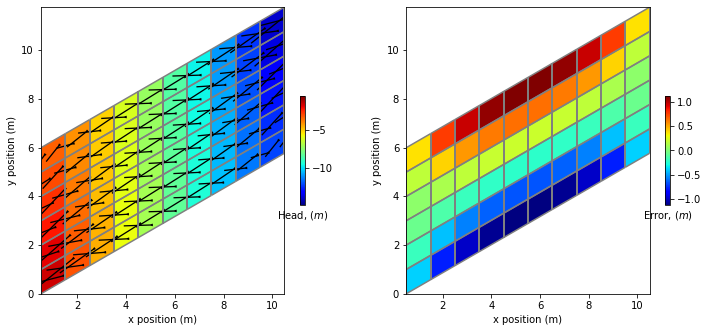

In [22]:
simulation(0)

Simulation results for scenario 1, which features:
1. nearly smooth channel boundary
2. xt3d formulation
3. isotropic connector cells

The connector cells are of primary interest in this scenario.

True

SPECIFIC DISCHARGE:
                                magnitude              angle
-----------------------  ----------------  -----------------
analytical               1.00000000000000  30.00000000000000
flat-tops, mid-channel   0.99999065710158  29.99719769056598
flat-tops, avg           0.99998129203967  29.99591034708580
flat-tops, min           0.99969604989999  29.98046393396793
flat-tops, max           1.00032541019383  30.01005815515823
connectors, mid-channel  0.99997325371157  29.99662878507202
connectors, avg          1.00001081575087  29.99884064566846
connectors, min          0.99982498262584  29.99305916215338
connectors, max          1.00027206636220  30.00376921219095
all, avg                 0.99999535094977  29.99730572736325
all, min                 0.99969604989999  29.98046393396793
all, max                 1.00032541019383  30.01005815515823


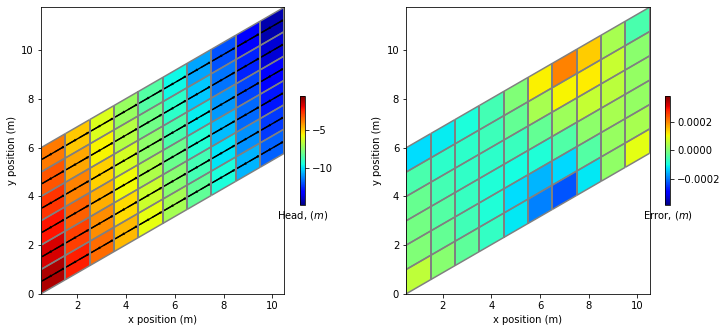

In [23]:
simulation(1)

Simulation results for scenario 2, which features:
1. zigzag channel boundary
2. standard conductance formulation
3. isotropic connector cells

All cells are of general interest in this scenario.

False

SPECIFIC DISCHARGE:
                                magnitude              angle
-----------------------  ----------------  -----------------
analytical               1.00000000000000  30.00000000000000
flat-tops, mid-channel   1.15546128837837   2.07923973658885
flat-tops, avg           1.18406323654072   9.45956767053727
flat-tops, min           0.61176928327957   1.11798605312292
flat-tops, max           2.01976033671115  54.81557643054801
connectors, mid-channel  1.83366841166822  51.17472983025733
connectors, avg          2.01292238719833  54.67697459326153
connectors, min          1.37061856705787  50.21821190114056
connectors, max          3.26861085672664  67.72245807920044
all, avg                 1.57875807018720  30.99166620516787
all, min                 0.61176928327957   1.11798605312292
all, max                 3.26861085672664  67.72245807920044


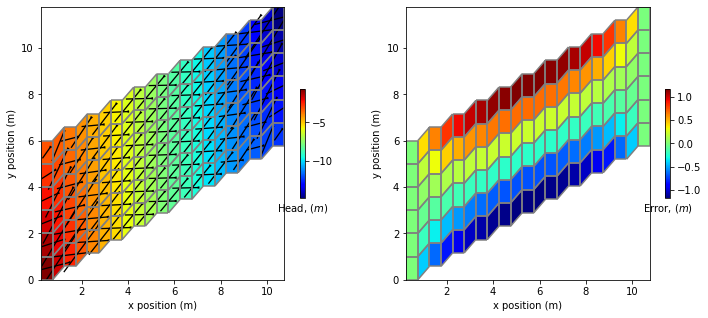

In [24]:
simulation(2)

Simulation results for scenario 3, which features:
1. zigzag channel boundary
2. xt3d formulation
3. isotropic connector cells

All cells are of general interest in this scenario.

True

SPECIFIC DISCHARGE:
                                magnitude              angle
-----------------------  ----------------  -----------------
analytical               1.00000000000000  30.00000000000000
flat-tops, mid-channel   0.99839516451698  28.42399331720190
flat-tops, avg           0.99416810445727  28.66214975576726
flat-tops, min           0.83453400448634  23.74109713579536
flat-tops, max           1.17710283853126  36.80809765778458
connectors, mid-channel  0.98925920981383  27.99751326975021
connectors, avg          1.00883625385414  29.94226310284509
connectors, min          0.86478546722218  25.63938117679358
connectors, max          1.17654655057339  35.05744708672042
all, avg                 1.00115293750340  29.27172754009003
all, min                 0.83453400448634  23.74109713579536
all, max                 1.17710283853126  36.80809765778458


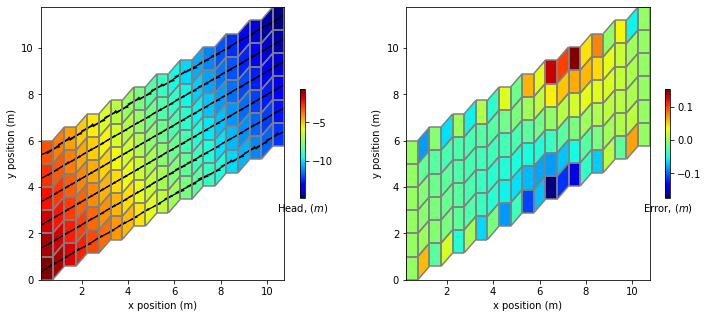

In [25]:
simulation(3)

Simulation results for scenario 4, which features:
1. zigzag channel boundary
2. xt3d formulation
3. anisotropic connector cells

All cells are of general interest in this scenario.

True

SPECIFIC DISCHARGE:
                                magnitude              angle
-----------------------  ----------------  -----------------
analytical               1.00000000000000  30.00000000000000
flat-tops, mid-channel   2.44321044056978  18.49451131321963
flat-tops, avg           2.78218860037423  12.87719503462354
flat-tops, min           1.88499711390551   5.91250584366325
flat-tops, max           4.85391434748789  18.91694791706044
connectors, mid-channel  3.58146104900561  49.10642629347645
connectors, avg          4.14333759115088  49.10766119961544
connectors, min          2.77527406047753  49.09300665274940
connectors, max          7.37699502424391  49.13324777143621
all, avg                 3.43035478645835  30.12979797033397
all, min                 1.88499711390551   5.91250584366325
all, max                 7.37699502424391  49.13324777143621


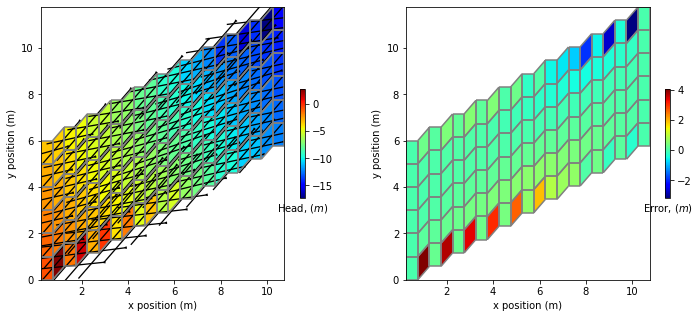

In [26]:
simulation(4)

Simulation results for scenario 5, which features:
1. stairstep channel boundary
2. standard conductance formulation
3. isotropic connector cells

The flat-top cells are of primary interest in this scenario.

False

SPECIFIC DISCHARGE:
                                   magnitude               angle
-----------------------  -------------------  ------------------
analytical                  1.00000000000000   30.00000000000000
flat-tops, mid-channel      1.15470053904012    0.00000000646204
flat-tops, avg              1.27293987686405   -0.16829723780266
flat-tops, min              0.58780507315219  -58.27939965124320
flat-tops, max              3.63844048732423   36.82556563471371
connectors, mid-channel   666.66771274896541   89.90076090515662
connectors, avg          1318.19969667929831   83.91839864560627
connectors, min           666.66768575129277  -89.99798945907622
connectors, max          4916.43891882345997   89.99300070054899
all, avg                  628.38091930659471   39.87298651620160
all, min                    0.58780507315219  -89.99798945907622
all, max                 4916.43891882345997   89.99300070054899


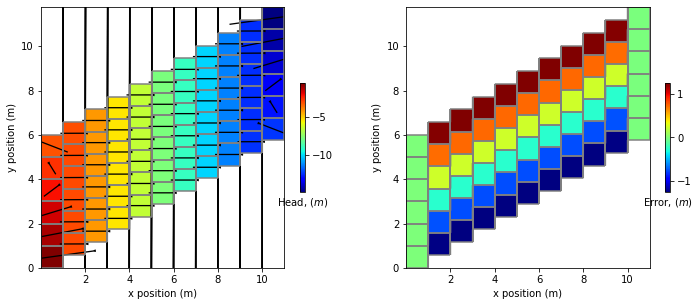

In [27]:
simulation(5)

Simulation results for scenario 6, which features:
1. stairstep channel boundary
2. xt3d formulation
3. isotropic connector cells

The flat-top cells are of primary interest in this scenario.

True

SPECIFIC DISCHARGE:
                                  magnitude               angle
-----------------------  ------------------  ------------------
analytical                 1.00000000000000   30.00000000000000
flat-tops, mid-channel     0.99204099017251   27.33785324682087
flat-tops, avg             0.99198956976788   28.93850326455501
flat-tops, min             0.67307947413713   22.00624309419596
flat-tops, max             1.33437371958468   47.97513145052348
connectors, mid-channel    1.53360706146805  -55.22681742806713
connectors, avg           33.95732714161579   43.68351074433223
connectors, min            0.89689152578601  -89.69418322914359
connectors, max          120.98741323238539   89.47233113237708
all, avg                  16.68976936588593   35.95993539778226
all, min                   0.67307947413713  -89.69418322914359
all, max                 120.98741323238539   89.47233113237708


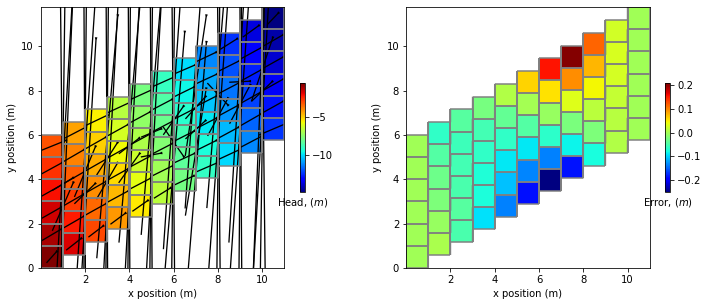

In [28]:
simulation(6)

Simulation results for scenario 7, which features:
1. stairstep channel boundary
2. xt3d formulation
3. anisotropic connector cells

The flat-top cells are of primary interest in this scenario.

True

SPECIFIC DISCHARGE:
                                  magnitude              angle
-----------------------  ------------------  -----------------
analytical                 1.00000000000000  30.00000000000000
flat-tops, mid-channel     0.89380615083221   4.74983000781981
flat-tops, avg             0.99019632737577  12.37811361571411
flat-tops, min             0.71482412884087  -0.91853353218798
flat-tops, max             1.58963734390511  43.72595794842615
connectors, mid-channel  512.00061306979740  89.90064108689874
connectors, avg          550.03943751946542  89.90065035970420
connectors, min          301.36759502109169  89.90063747796786
connectors, max          870.61357872366000  89.90066737336544
all, avg                 262.44221594265662  49.29360730332844
all, min                   0.71482412884087  -0.91853353218798
all, max                 870.61357872366000  89.90066737336544


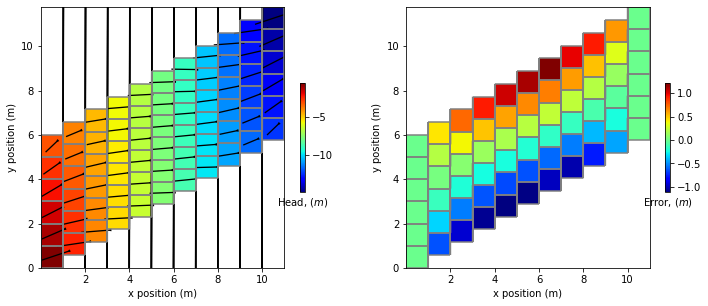

In [29]:
simulation(7)